# OsuLearn
##### Machine Learning para jogar mapas de osu!

^^^

Isso aí, tô sem mais nada pra fazer, bora criar uma IA que joga osu! )o)

## Importar umas coisas...

In [1]:
# Machine Learning
import tensorflow as tf
import numpy as np
import pandas as pd

# Plotagem
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib import animation, rc

Path = mpath.Path

# Utilidades
import os
import re
import lzma
import time

## Constantes

Aqui tem uns caminhos para os arquivos que precisamos:

In [2]:
# Pasta do osu!
OSU_FOLDER = "C:\\" + os.path.join("Program Files (x86)", "Jogos", "osu!")

# Nome do beatmap
#BEATMAP = os.path.join('499478 Utsu-P - TRAUMATIC', 'Utsu-P - TRAUMATIC (Cryptic) [EXTREME].osu')
BEATMAP = os.path.join('353412 Sakuzyo - Imprinting', 'Sakuzyo - Imprinting (Necroluttah) [Arles AR9.5].osu')

# Nome do arquivo de replay
#REPLAY = 'BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu.osr'
REPLAY = 'BzMasked - Sakuzyo - Imprinting [Arles AR9.5] (2018-12-17) Osu.osr'

E uns valores pra ajuste nas visualizações:

In [3]:
CIRCLE_FADEOUT = 50
SLIDER_FADEOUT = 100

## Leitura do arquivo de Beatmap

O formato do arquivo está especificado no [site do osu!](https://osu.ppy.sh/help/wiki/osu!_File_Formats/Osu_(file_format)/).

In [4]:
def next_line(file):
    line = file.readline()
    while line != '' and re.match(r"[^\n\r\s]", line) == None:
        line = file.readline()
    return line

def read_section_header(file):
    header = next_line(file)
    m = re.match(r"^\s*\[(\S+)\]\s*$", header)
    
    if m is None:
        return None
    return m[1]

def parse_value(v):
    if v.isdigit():
        return int(v)
    elif v.replace('.', '', 1).isdigit():
        return float(v)
    else:
        return v
        
# Seção do tipo Chave: Valor
def read_type_a_section(file):
    d = dict()
    
    line = file.readline()
    while line != '' and re.match(r"[^\n\r\s]", line) != None:
        m = re.match(r"^\s*(\S+)\s*:\s*(.*)\s*\r?\n$", line)
        if m is None:
            raise RuntimeError("Invalid file")
        else:
            d[m[1]] = parse_value(m[2])
        
        line = file.readline()
    
    return d

# Seção do tipo a,b,c,...,d
def read_type_b_section(file):
    l = list()
        
    line = file.readline()
    while line != '' and re.match(r"[^\n\r\s]", line) != None:
        l.append(list(map(parse_value, line.rstrip("\r\n").split(','))))
        line = file.readline()
    
    return l

def load_beatmap(filename):
    file = open(filename, 'r', encoding='utf8')
    
    # Versão do formato
    version = file.readline()
    
    # Seções de informações do mapa
    general = {}
    metadata = {}
    difficulty = {}
    timing_points = {}
    hit_objects = {}
    
    section = read_section_header(file)
    while section != None:
        if section == "General":
            general = read_type_a_section(file)
        if section == "Editor":
            editor = read_type_a_section(file)
        if section == "Metadata":
            metadata = read_type_a_section(file,)
        if section == "Difficulty":
            difficulty = read_type_a_section(file)
        if section == "Events":
            events = read_type_b_section(file)
        if section == "TimingPoints":
            timing_points = read_type_b_section(file)
        if section == "Colours":
            colours = read_type_a_section(file)
        if section == "HitObjects":
            hit_objects = read_type_b_section(file)
        
        section = read_section_header(file)
    
    file.close()
    
    return general, metadata, difficulty, timing_points, hit_objects

def approach_rate(beatmap):
    ar = difficulty["ApproachRate"]
    if ar <= 5:
        preempt = 1200 + 600 * (5 - ar) / 5
        fade_in = 800 + 400 * (5 - ar) / 5
    else:
        preempt = 1200 - 750 * (ar - 5) / 5
        fade_in = 800 - 500 * (ar - 5) / 5
        
    return preempt, fade_in

def slider_duration(beatmap, obj):
    _, _, difficulty, timing_points, _ = beatmap
    
    # Timing point
    last_non_negative = 0
    timing_point = timing_points[0]
    for tp in timing_points:
        if tp[0] > obj[2]:
            break
        d = float(tp[1])
        if d > 0:
            last_non_negative = d
        timing_point = tp
        
    beat_duration = float(timing_point[1])
    if beat_duration < 0:
        beat_duration = last_non_negative * -beat_duration / 100
    
    return beat_duration * obj[7] / (100 * difficulty['SliderMultiplier'])

# Pega o objeto visível na tela em dado momento
def beatmap_objects_at_time(beatmap, t):
    _, _, _, _, hit_objects = beatmap
    i = 0
    r = []
    
    preempt, fade = approach_rate(beatmap)
    
    for obj in hit_objects:
        if obj[2] > t:
            break
        if obj[3] & 8 and t < obj[5]:
            r.append(obj)
        elif obj[3] & 2:
            if t < obj[2] + preempt + slider_duration(beatmap, obj) + SLIDER_FADEOUT:
                r.append(obj)
        elif t < obj[2] + preempt + CIRCLE_FADEOUT:
            r.append(obj)
        
    return r

In [5]:
beatmap_filename = os.path.join(OSU_FOLDER, "Songs", BEATMAP)
beatmap = load_beatmap(beatmap_filename)
general, metadata, difficulty, timing_points, hit_objects = beatmap

print()
print('Mapa:', metadata['ArtistUnicode'], '-', metadata['TitleUnicode'])
print('Autor:', metadata['Creator'])
print('Dificuldade: ', metadata['Version'])


Mapa: Sakuzyo - Imprinting
Autor: Necroluttah
Dificuldade:  Arles AR9.5


## Leitura do arquivo de Replay

O formato do arquivo está especificado no [site do osu!](https://osu.ppy.sh/help/wiki/osu!_File_Formats/Osr_(file_format)/).

### Tipos de dados

Os arquivos de replay do osu! são binários, então vamos precisar de umas funções auxiliares pra ler as coisas dele:

In [6]:
def read_byte(file):
    return ord(file.read(1))

def read_short(file):
    return read_byte(file) + (read_byte(file) << 8)

def read_int(file):
    return read_short(file) + (read_short(file) << 16)

def read_long(file):
    return read_int(file) + (read_int(file) << 32)

def read_uleb128(file):
    n = 0
    i = 0
    while True:
        byte = read_byte(file)
        n += (byte & 0x7F) << i
        if byte & 0x80 != 0:
            i += 7
        else:
            return n

def read_binary_string(file):
    while True:
        flag = read_byte(file)
        if flag == 0x00:
            return ""
        elif flag == 0x0b:
            length = read_uleb128(file)
            return file.read(length).decode('utf8')
        else:
            raise RuntimeError("Invalid file")

### Arquivo .osr

Aqui a gente lê o arquivo e pega as informações relevantes pra usar. Temos a seguinte função pra carregar o arquivo:

In [7]:
def load_replay(filename):
    file = open(filename, "rb")
    game_mode = read_byte(file)

    # Sem minigames
    if game_mode != 0:
        return None

    # Versão do osu! e hash do mapa. A gente ignora.
    osu_version = read_int(file)
    map_md5 = read_binary_string(file)
    
    # Nome do jogador.
    player = read_binary_string(file)

    # Hash do replay. Dava pra usar, mas é meio desnecessário.
    replay_md5 = read_binary_string(file)

    # Acertos
    n_300s = read_short(file)
    n_100s = read_short(file)
    n_50s = read_short(file)
    n_geki = read_short(file)
    n_katu = read_short(file)
    n_misses = read_short(file)

    # Score e combo
    score = read_int(file)
    max_combo = read_short(file)
    perfect = read_byte(file)

    # Acurácia
    total = n_300s + n_100s + n_50s + n_misses
    acc = (n_300s + n_100s / 3 + n_50s / 6) / total

    # Mods (ignora)
    mods = read_int(file)

    # Gráfico de vida. Vide site para o formato.
    life_graph = read_binary_string(file)
    life_graph = [t.split('|') for t in life_graph.split(',')[:-1]]

    # Timestamp do replay (ignora)
    timestamp = read_long(file)
    
    # Informações do replay em si
    replay_length = read_int(file)
    replay_data = lzma.decompress(file.read(replay_length)).decode('utf8')

    replay = [t.split("|") for t in replay_data.split(',')[:-1]]
    replay = [(int(w), float(x), float(y), int(z)) for w, x, y, z in replay]

    # Não usado
    _ = read_long(file)
    
    file.close()

    info = (player, score, max_combo, perfect, total, acc)
    hits = (n_300s, n_100s, n_50s, n_geki, n_katu, n_misses)
    return info, hits, life_graph, replay

In [8]:
info, hits, life_graph, replay = load_replay(os.path.join(OSU_FOLDER, "Replays", REPLAY))

player, score, max_combo, perfect, total, acc = info
n_300s, n_100s, n_50s, n_geki, n_katu, n_misses = hits

## Informações do Replay

Legal, carregamos o replay, isso foi o que achamos:


Player: BzMasked

Pontuação Total: 3366286

  677 x 300	   75 x 激
   43 x 100	    9 x 喝
    7 x 50	   11 x Erros

Acurácia: 93.83%
Combo Máximo: 532x 



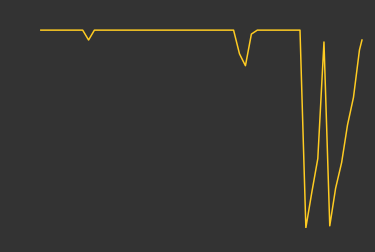

In [9]:
print()
print("Player:", player)

print()
print("Pontuação Total:", score)
print()
print("%5d x 300\t%5d x 激" % (n_300s, n_geki))
print("%5d x 100\t%5d x 喝" % (n_100s, n_katu))
print("%5d x 50\t%5d x Erros" % (n_50s, n_misses))
print()

print("Acurácia: %.2f%%" % (100 * acc))
print("Combo Máximo: %dx" % max_combo, "(Perfect)" if perfect else "")
print()

%matplotlib inline

u = [int(t[0]) / 1000 for t in life_graph]
v = [float(t[1]) for t in life_graph]

fig = plt.figure(facecolor='#333333')
plt.xlim(-1, max(u) + 1)
plt.ylim(0, 1.1)
plt.axis('off')
plt.plot(u, v, '#ffcc22')
plt.show()

## Visualização

Aqui temos uma previsualização do replay, também:

In [10]:
def draw_cursor(ax, x, y, z):
    # Mostra o cursor
    keys = int(z)
    if keys & 0x01:
        cursor = 'ro'
    elif keys & 0x02:
        cursor = 'go'
    else:
        cursor = 'y+'
    ax.plot([x], [384 - y], cursor)
    
def draw_slider(ax, radius, t, obj):
    path = obj[5].split("|")
    stype = path.pop(0)

    points = [(obj[0], 384 - obj[1])] + [(int(x), 384 - int(y)) for x, y in [t.split(':') for t in path]]
    codes = []

    if stype == 'L':
        codes.append(Path.MOVETO)
        for i in range(1, len(points)):
            codes.append(Path.LINETO)
    elif stype == 'P':
        codes.append(Path.MOVETO)
        codes.append(Path.CURVE3)
        codes.append(Path.CURVE3)
    else:
        n = 0
        for i in range(0, len(points)):
            n += 1
            if i + 1 == len(points) or n == 4 or (i + 1 < len(points) and points[i] == points[i + 1]):
                if n == 2:
                    codes.append(Path.MOVETO)
                    codes.append(Path.LINETO)
                elif n == 3:
                    codes.append(Path.MOVETO)
                    codes.append(Path.CURVE3)
                    codes.append(Path.CURVE3)
                elif n == 4:
                    codes.append(Path.MOVETO)
                    codes.append(Path.CURVE4)
                    codes.append(Path.CURVE4)
                    codes.append(Path.CURVE4)
                n = 0
                
    preempt, fade = approach_rate(beatmap)

    duration = slider_duration(beatmap, obj)
    if t < obj[2] + preempt + duration:
        alpha = 1
    else:
        alpha = 1 - (t - (obj[2] + preempt + duration)) / SLIDER_FADEOUT
                
    slider = mpatches.PathPatch(
        Path(points, codes),
        fc="none", capstyle='round', transform=ax.transData, fill=False,
        edgecolor=(1.0, 1.0, 1.0, alpha), linewidth=radius, joinstyle='bevel', zorder=-2
    )
    ax.add_patch(slider)
    slider = mpatches.PathPatch(
        Path(points, codes),
        fc="none", capstyle='round', transform=ax.transData, fill=False,
        edgecolor="#333333", linewidth=radius-4, joinstyle='bevel', zorder=-1
    )
    ax.add_patch(slider)

last_nc = 0
current_color = 0

def draw_hit_objects(ax, t, objs):
    global current_color, last_nc
    
    circles = ([], [], [])
    radius = (27.2 - 2.24 * difficulty['CircleSize'])
    combo_colors = [(1.0, 0, 0), (0, 1.0, 0), (0, 1.0, 0), (1.0, 1.0, 0)]
    
    # Sliders
    for obj in objs:
        color = current_color
        if obj[3] & 4 and obj[2] > last_nc:
            last_nc = obj[2]
            current_color += 1
            current_color %= len(combo_colors)
            color = current_color
        elif obj[2] <= last_nc:
            color = (len(combo_colors) + current_color - 1) % len(combo_colors)
            
        # Spinner
        if obj[3] & 8:
            ax.plot([obj[0]], [obj[1]], 'yo', fillstyle='none', markersize=128)
            
        else:
            # Slider
            if obj[3] & 2:
                draw_slider(ax, radius, t, obj)
                
            # Círculo (Slider também tem)
            circles[0].append(obj[0])
            circles[1].append(384 - obj[1])

            preempt, fade = approach_rate(beatmap)

            if t > obj[2] + preempt:
                alpha = 1 - (t - obj[2] - preempt) / CIRCLE_FADEOUT
            elif t < obj[2] + fade:
                alpha = 1 - ((obj[2] + fade) - t) / fade
            else:
                alpha = 1
            alpha = max([0, min(1, alpha)])
            
            
            r, g, b = combo_colors[color]
            circles[2].append((r, g, b, alpha))
            
    ax.scatter(circles[0], circles[1], color=circles[2], s=radius ** 2)

<IPython.core.display.Javascript object>


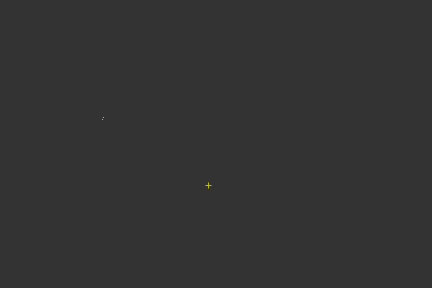

<IPython.core.display.Javascript object>


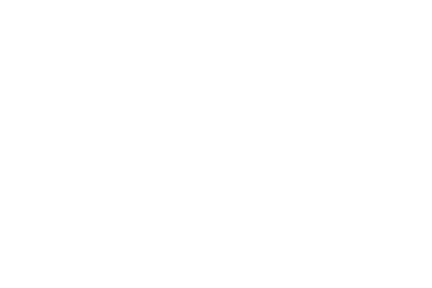

In [11]:
%matplotlib notebook

# Figura interativa...
plt.ion()

fig = plt.figure(facecolor='#333333')
ax = fig.add_subplot(1, 1, 1)

ax.clear()
ax.axis('off')
fig.canvas.draw()

plt.show()

delta = 0
_, tt = approach_rate(beatmap)
for t in replay:
    w, x, y, z = t
    
    if w > 0:
        tt += w
        
    sec = w / 1000
    
    # Frame skip
    if delta > sec:
        delta -= sec
        continue
    
    # Espera o tempo especificado entre o estado atual e o anterior
    # no arquivo de replay
    if sec > 0:
        time.sleep(sec - delta)
        delta = 0
    
    start = time.time()

    # Limpa tudo
    ax.clear()
    ax.axis('off')
    ax.set_xlim((-32, 512 + 32))
    ax.set_ylim((-32, 384 + 32))
    fig.canvas.draw_idle()
    
    # Desenha o objeto do mapa
    objs = beatmap_objects_at_time(beatmap, tt)
    
    if len(objs) > 0:
        draw_hit_objects(ax, tt, objs)
        
    draw_cursor(ax, x, y, z)
    fig.canvas.draw()
    
    # Calcula o atraso
    delta += time.time() - start